In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import sys
import glob
import itertools
from pathlib import Path
cd= Path.cwd().parent.parent
sys.path.append(str(cd))


from func.Models import MultiTaskNet_simple as MultiTaskNet
from func.dataloads import LiverUnlabeledDataset, LiverDataset
from torch.utils.data import DataLoader

INPUT_SHAPE = (128, 128,128) # ( D, H, W)
NUM_CLASSES = 3  # Background, Segment 1, Segment 2
LATENT_DIM = 256 # RNN batch
BATCH_SIZE = 4
TIME_STEPS = 10 # Time series size 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Using device: {device} ---") # Good to confirm this says 'cpu'
MODEL_PATH = Path.cwd().parent.parent / "Trained_models" /"Multi_small.pth"
print(f"Model path: {MODEL_PATH}")

Test_dir = Path.cwd().parent.parent / "Task03_Liver_rs" 

model = MultiTaskNet(
    in_channels=1, 
    num_classes=NUM_CLASSES, 
    latent_dim=LATENT_DIM    
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
print(f"Loaded model weights from {MODEL_PATH}")

model.eval() 

labeled_dataset = LiverDataset(Test_dir, Test_dir, target_size= INPUT_SHAPE)
test_loader = DataLoader(labeled_dataset, batch_size=1, shuffle=True)

# Unpack both the image and the target mask
x_labeled, y_labeled = next(iter(test_loader))

# Move them to the device
x_labeled = x_labeled.to(device)
y_labeled = y_labeled.to(device)

print(f"Loaded one labeled image with shape: {x_labeled.shape}")

with torch.no_grad(): # We don't need to calculate gradients
    seg_out, recon_out, _ = model(x_labeled)

print(f"Segmentation output shape: {seg_out.shape}")
print(f"Reconstruction output shape: {recon_out.shape}")


--- Using device: cpu ---
Model path: /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Trained_models/Multi_small.pth
Loaded model weights from /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Trained_models/Multi_small.pth
/zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs
/zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs
Found 28 image/label pairs.
Loaded one labeled image with shape: torch.Size([1, 1, 128, 128, 128])


/tmp/ipykernel_3616675/3447099928.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Segmentation output shape: torch.Size([1, 3, 128, 128, 128])
Reconstruction output shape: torch.Size([1, 1, 128, 128, 128])


In [2]:
# Path to your main data directory
DATA_ROOT = Path.cwd().parent.parent / "Task03_Liver_rs"

# The specific label file you want to inspect
# (Change 'liver_10.nii' to a real filename in your folder)
FILE_NAME = "liver_10.nii" 

# --- 2. BUILD FULL PATH ---
lbl_path = DATA_ROOT / "labelsTr" / FILE_NAME

print(f"--- Inspecting File: {lbl_path} ---")

try:
    # --- 3. LOAD NIFTI FILE ---
    lbl_nii = nib.load(lbl_path)

    # --- 4. (Your Request) PRINT THE HEADER ---
    print("\n--- NIfTI HEADER INFO ---")
    header = lbl_nii.header
    print(header)
    
    # You can also print specific fields you might care about
    print(f"\nDatatype: {header.get_data_dtype()}")
    print(f"Dimensions: {header['dim']}")
    print(f"Voxel Spacing: {header['pixdim'][1:4]}")


    # --- 5. (Your Goal) FIND THE SEGMENTATION CLASSES ---
    print("\n--- SEGMENTATION CLASSES (Unique Values) ---")
    
    # Load the actual data into a numpy array
    lbl_data = lbl_nii.get_fdata()
    
    # Find all unique values in the array
    unique_values = np.unique(lbl_data)
    
    print(f"Found unique values: {unique_values}")
    print(f"This means you have {len(unique_values)} classes.")
    print("(e.g., [0. 1.] means background and liver)")
    print("(e.g., [0. 1. 2.] means background, liver, and something else)")

except FileNotFoundError:
    print(f"\n--- ERROR: File not found ---")
    print(f"Check if '{FILE_NAME}' exists at that path.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Inspecting File: /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs/labelsTr/liver_10.nii ---

--- NIfTI HEADER INFO ---
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'')
dim_info        : 0
dim             : [  3 197 197 167   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 2. 2. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : unknown
sform_co

Loading image: /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs/imagesTr/liver_10.nii
Loading label: /zhome/d2/4/167803/Desktop/Deep_project/02456-final-project/Task03_Liver_rs/labelsTr/liver_10.nii

Original Image Shape (W, H, D): (197, 197, 167)
Original Label Shape (W, H, D): (197, 197, 167)


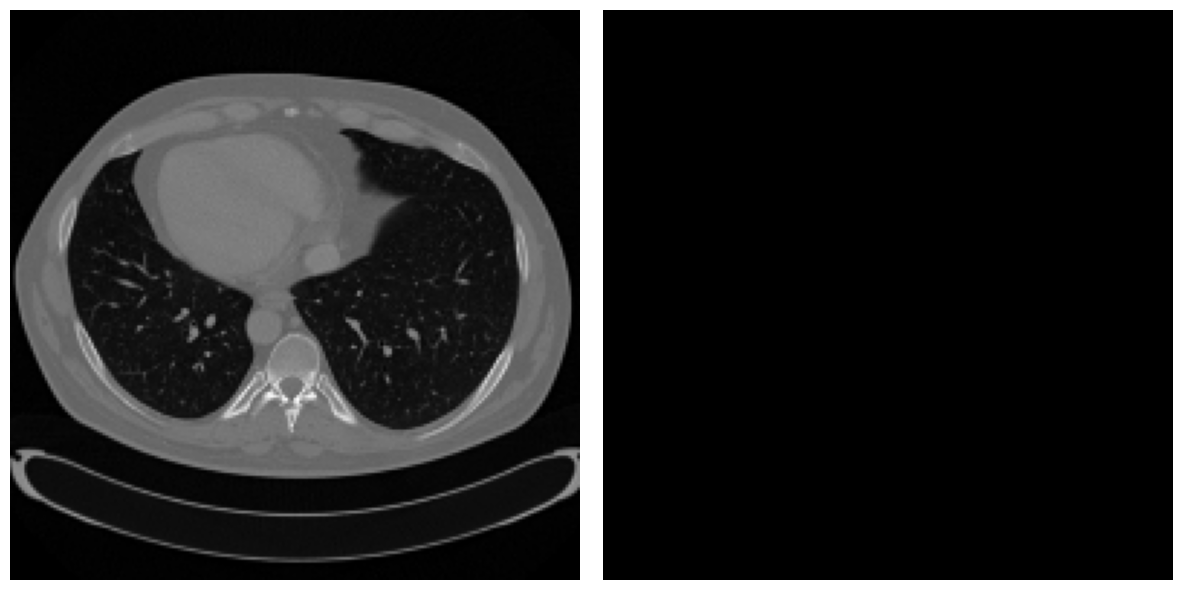

In [8]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path



# Path to your main data directory
DATA_ROOT = Path.cwd().parent.parent / "Task03_Liver_rs"

# The specific file you want to look at
FILE_NAME = "liver_10.nii" 

# The slice number you want to see (along the Z-axis)


# --- 2. BUILD FULL PATHS ---
img_path = DATA_ROOT / "imagesTr" / FILE_NAME
lbl_path = DATA_ROOT / "labelsTr" / FILE_NAME

print(f"Loading image: {img_path}")
print(f"Loading label: {lbl_path}")

try:
    # --- 3. LOAD NIFTI FILES ---
    img_nii = nib.load(img_path)
    lbl_nii = nib.load(lbl_path)

    # --- 4. GET NUMPY DATA (NO RESHAPING) ---
    # This loads data in the standard (Width, Height, Depth) format
    img_data = img_nii.get_fdata()
    lbl_data = lbl_nii.get_fdata()

    print(f"\nOriginal Image Shape (W, H, D): {img_data.shape}")
    print(f"Original Label Shape (W, H, D): {lbl_data.shape}")

    # --- 5. SELECT THE SLICE ---
    # We slice along the 3rd dimension (Depth)
    img_slice = img_data[:, :, i+130]
    lbl_slice = lbl_data[:, :, i+130]

    # --- 6. PLOT ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # We use .T (transpose) because NIfTI (W, H) and imshow(H, W) are flipped
    # 'origin="lower"' is standard for medical images
    ax1.imshow(img_slice.T, cmap="gray", origin="lower")
    ax1.axis('off')

    ax2.imshow(lbl_slice.T, cmap="gray", origin="lower")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("\n--- ERROR ---")
    print(f"File not found. Does '{FILE_NAME}' exist in 'imagesTr' and 'labelsTr'?")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Your SLICE_TO_SHOW might be out of bounds for this image's depth.")

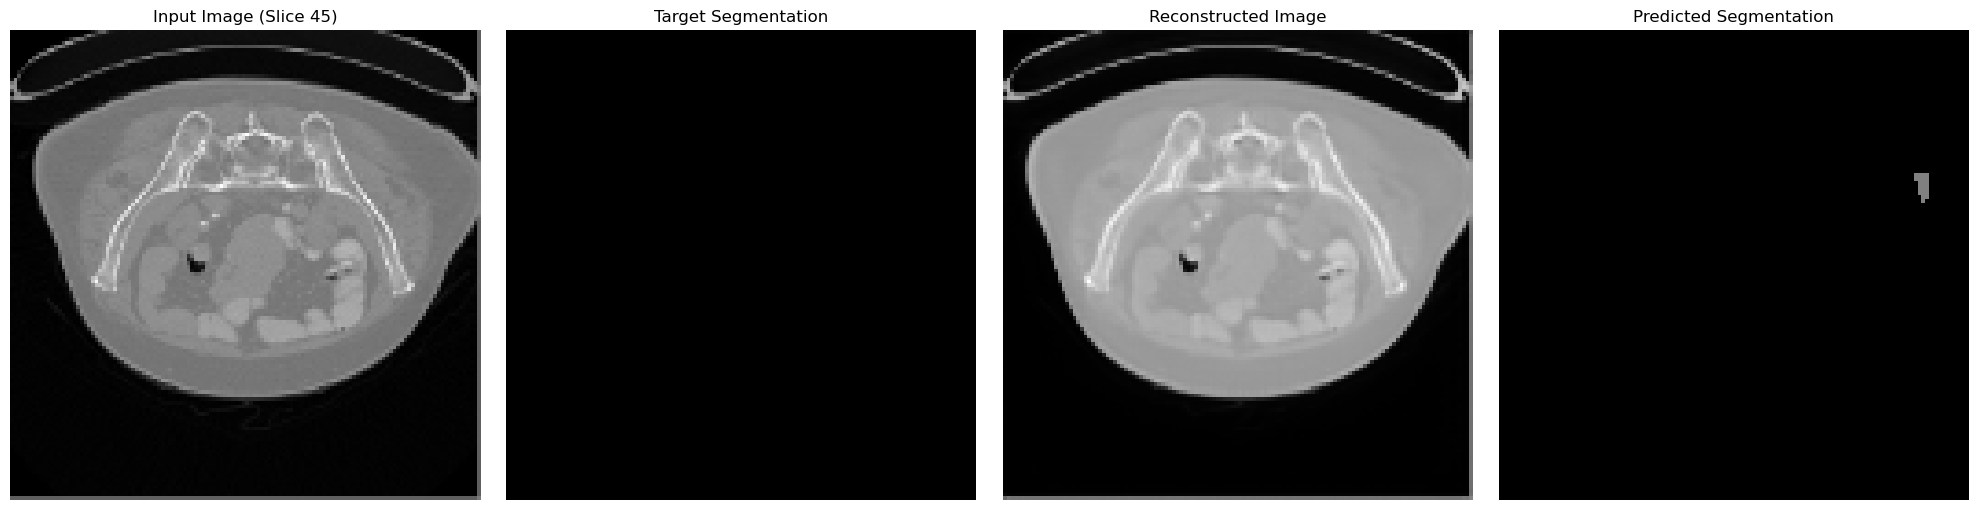

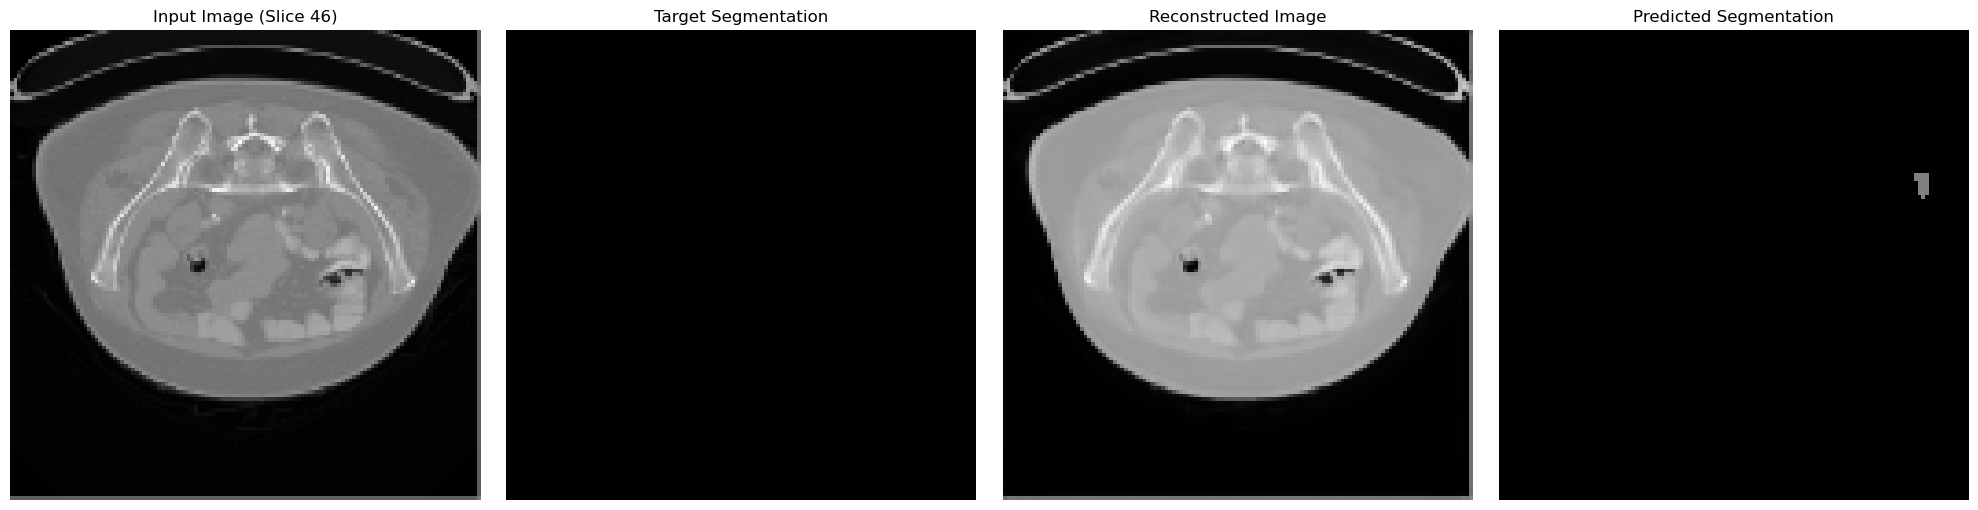

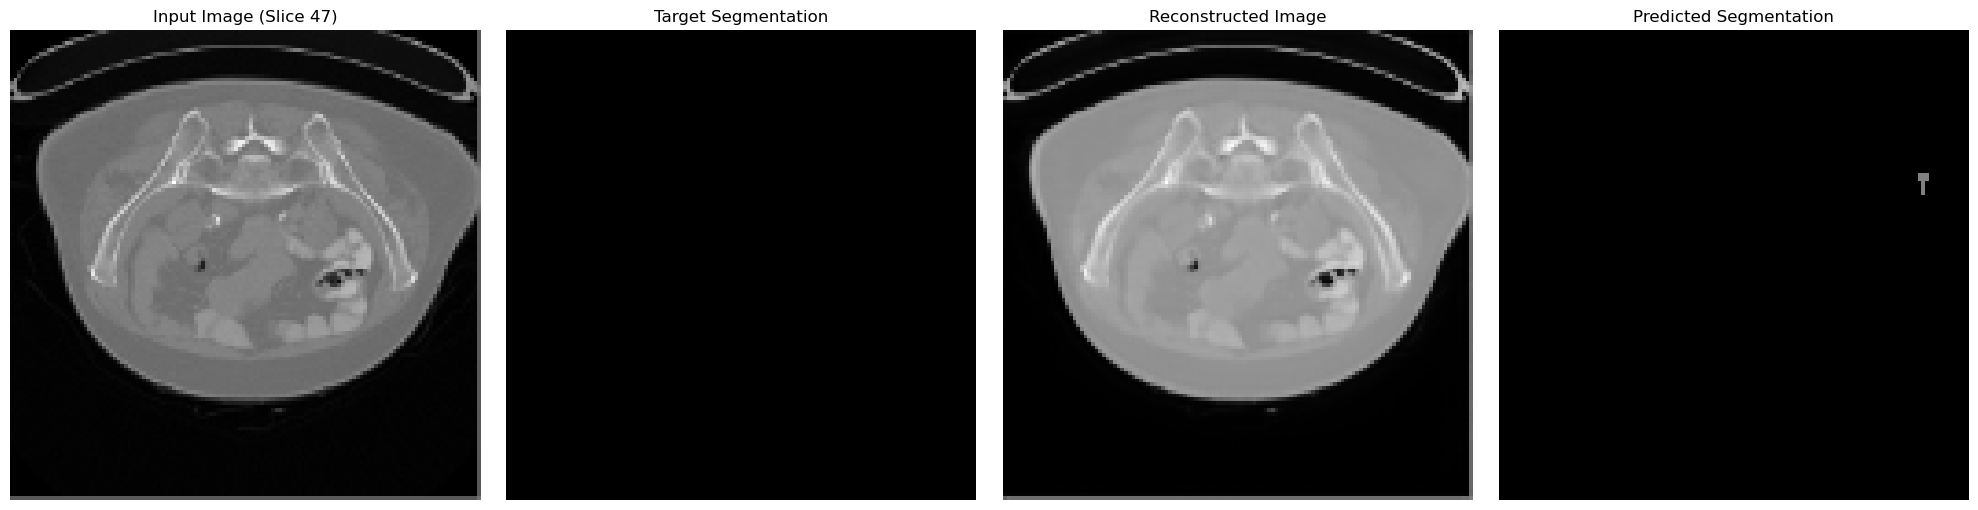

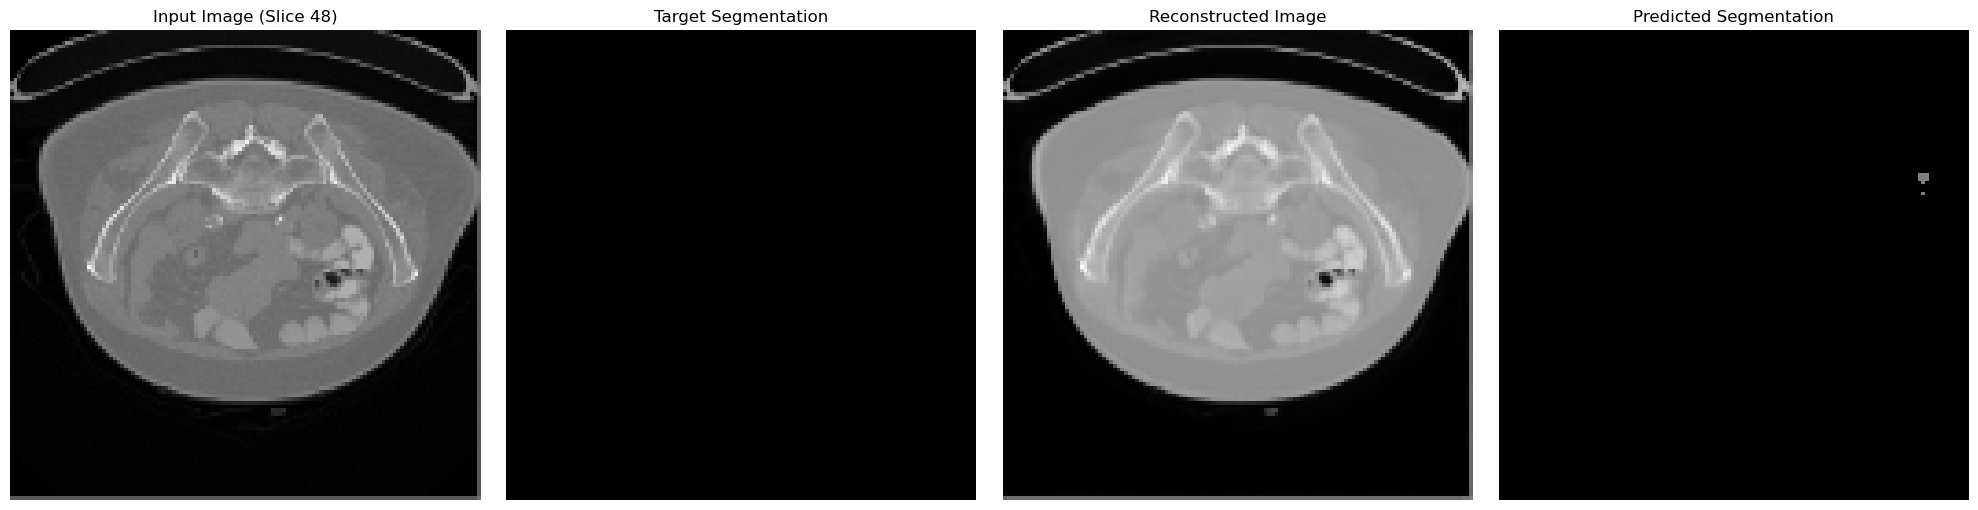

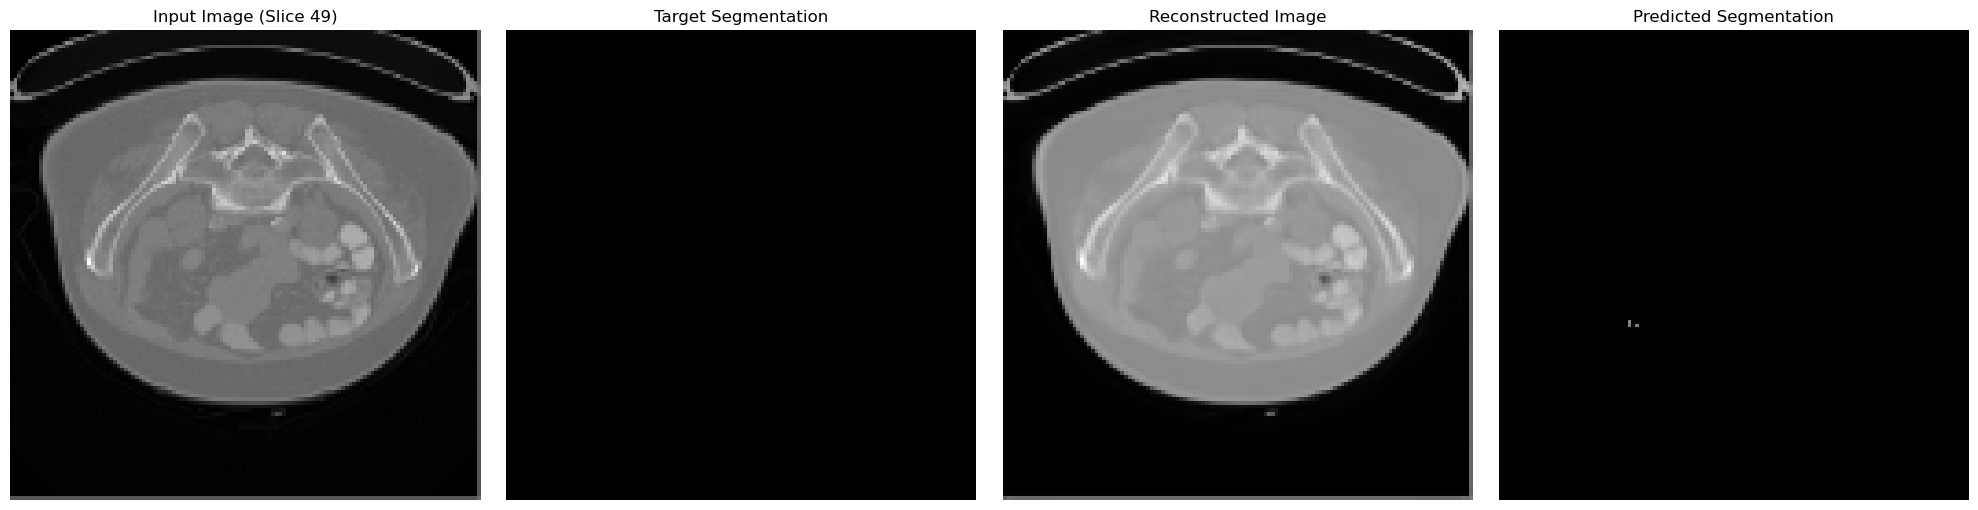

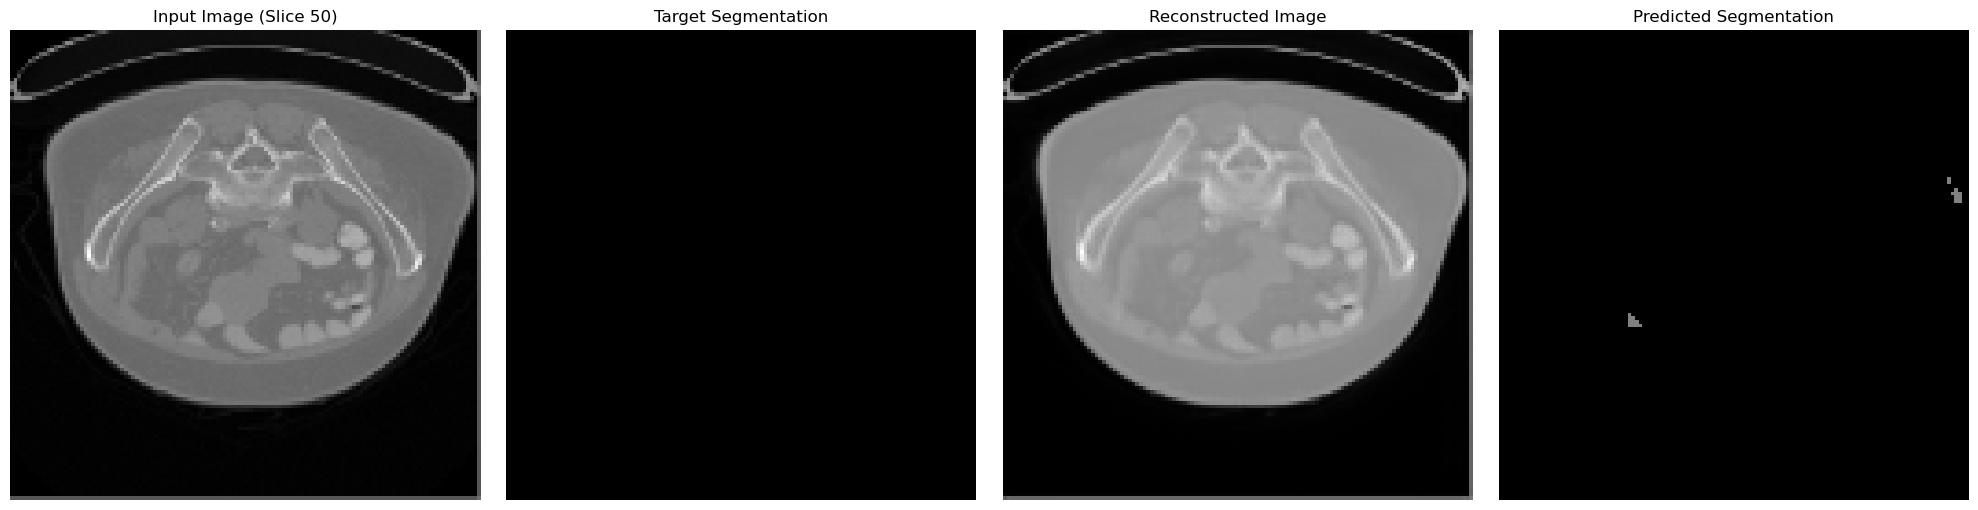

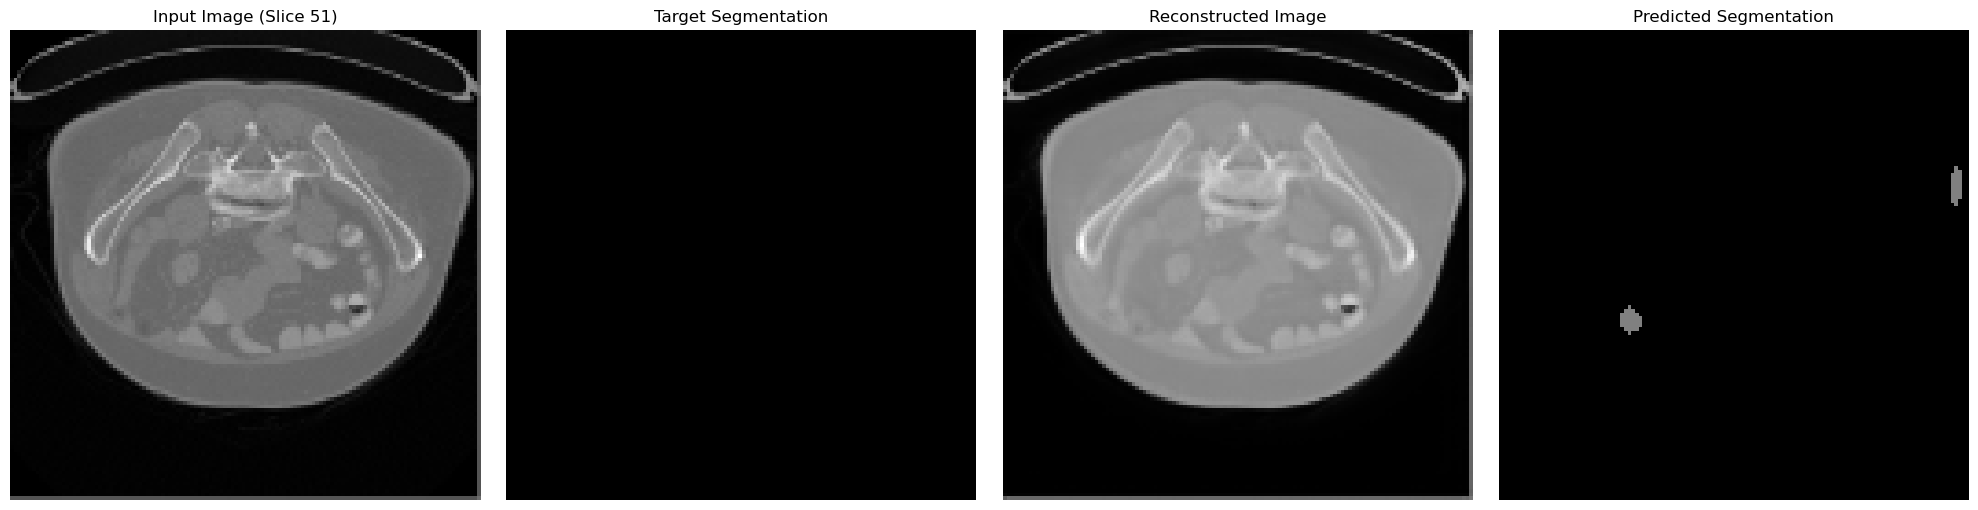

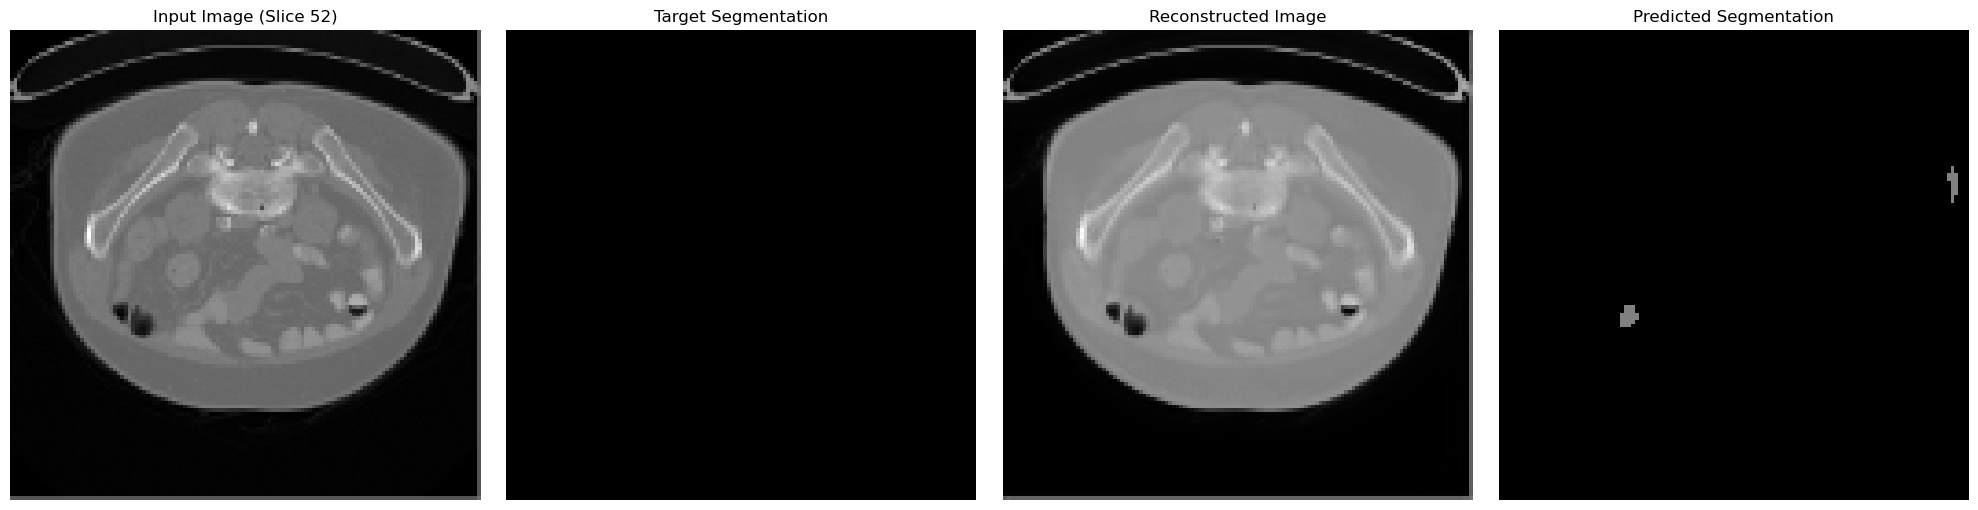

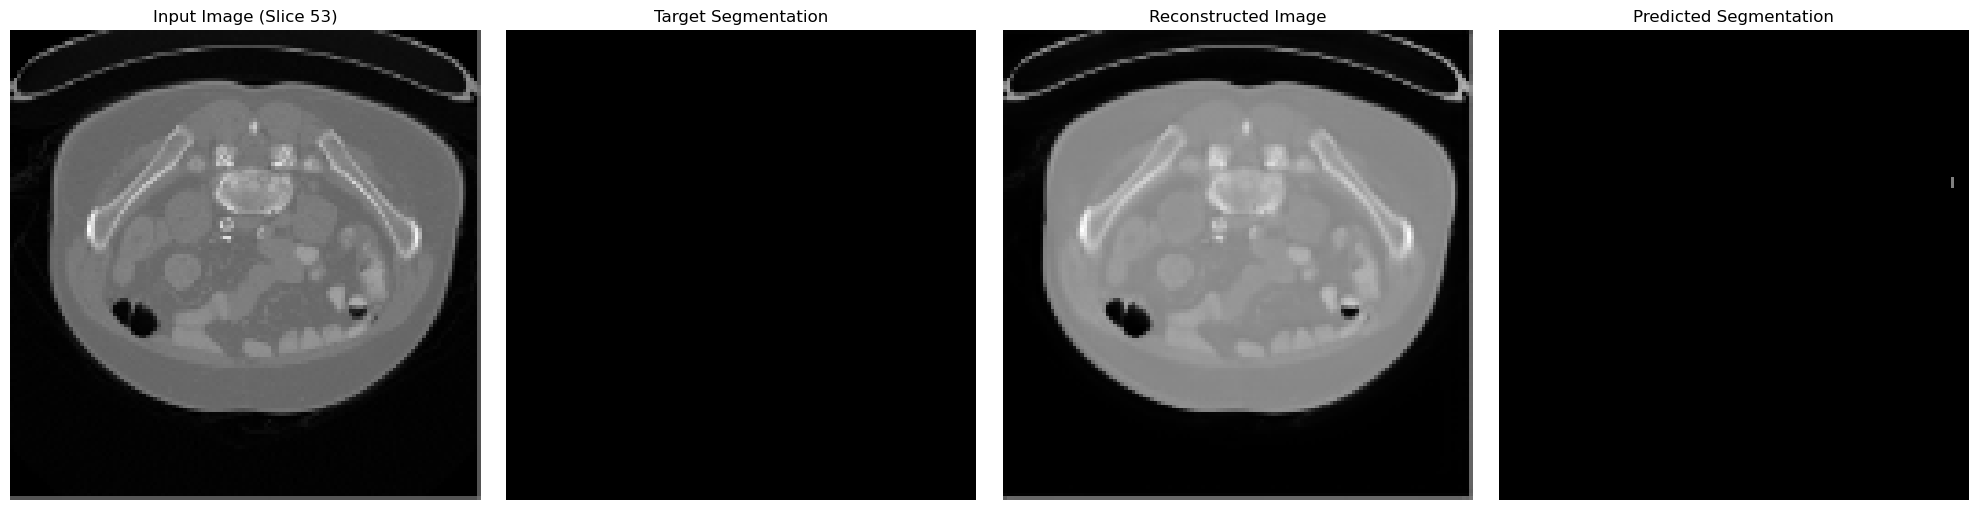

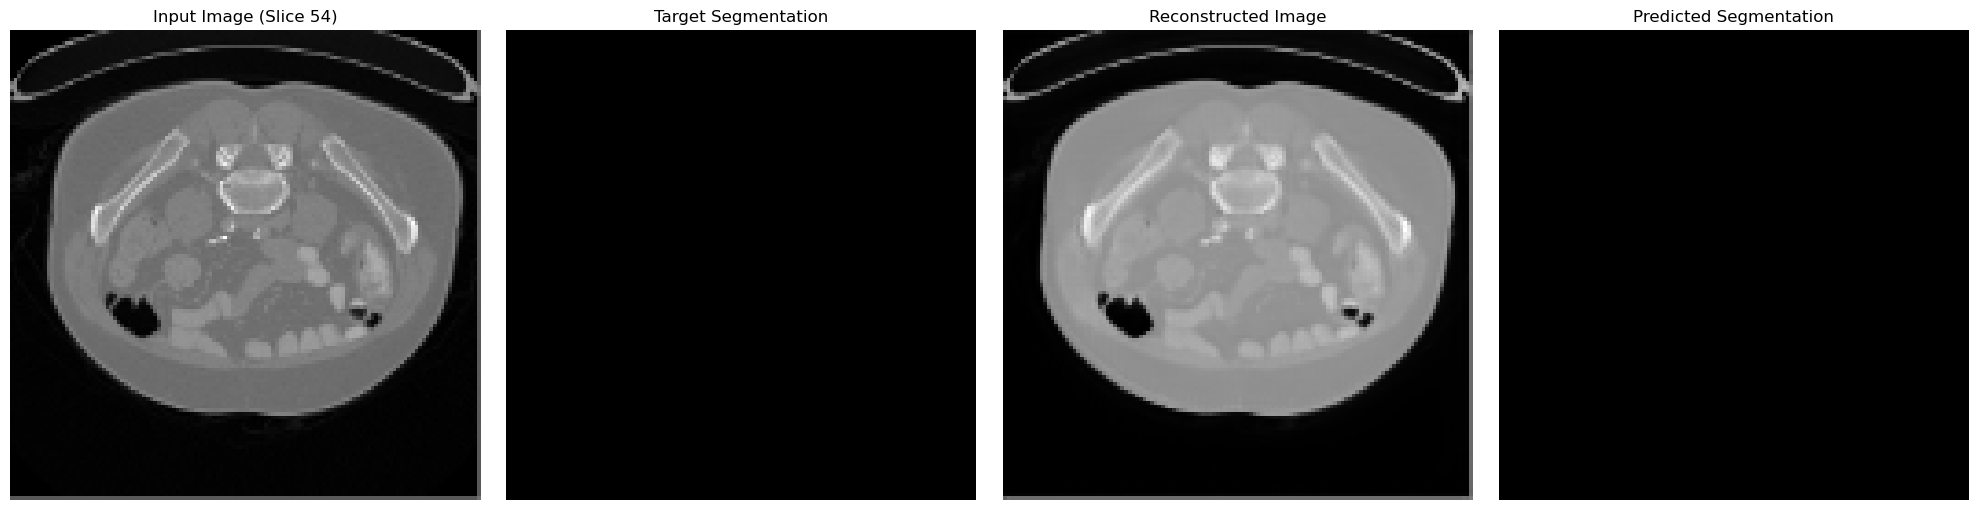

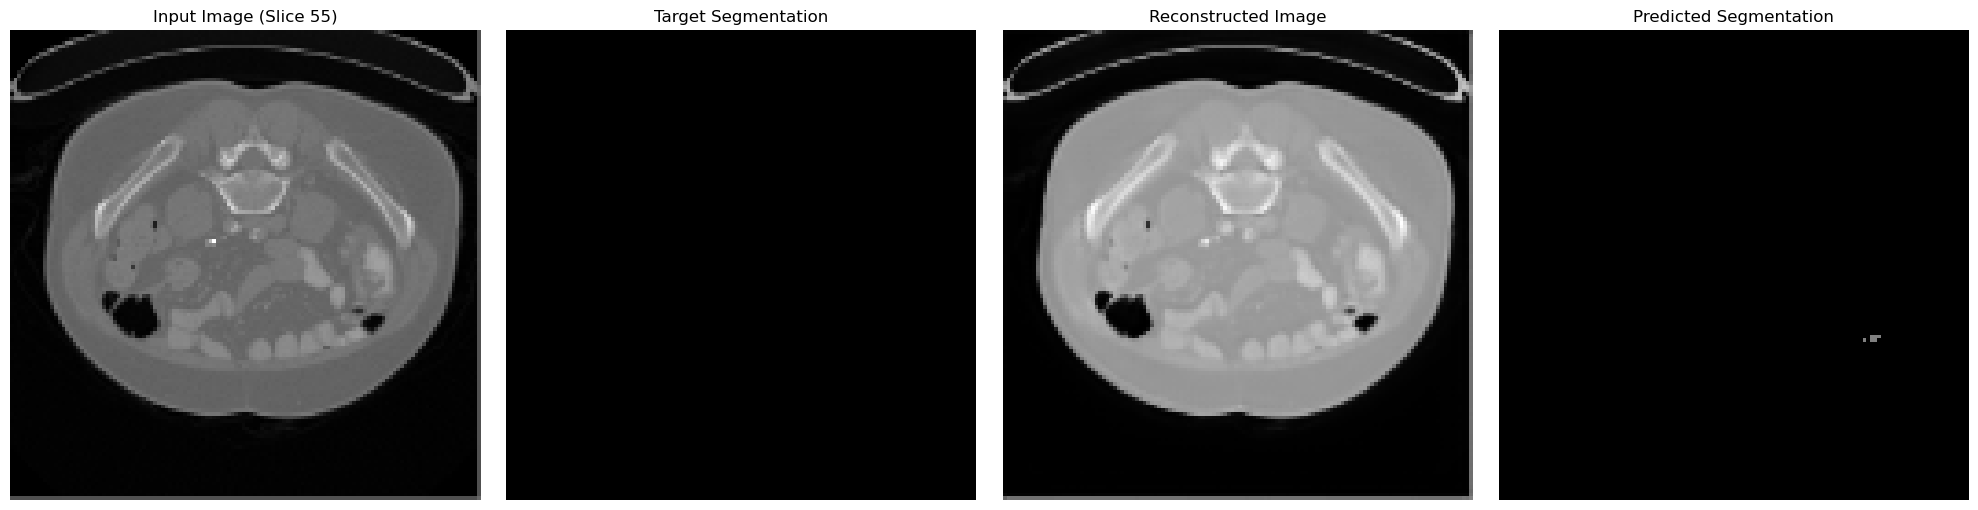

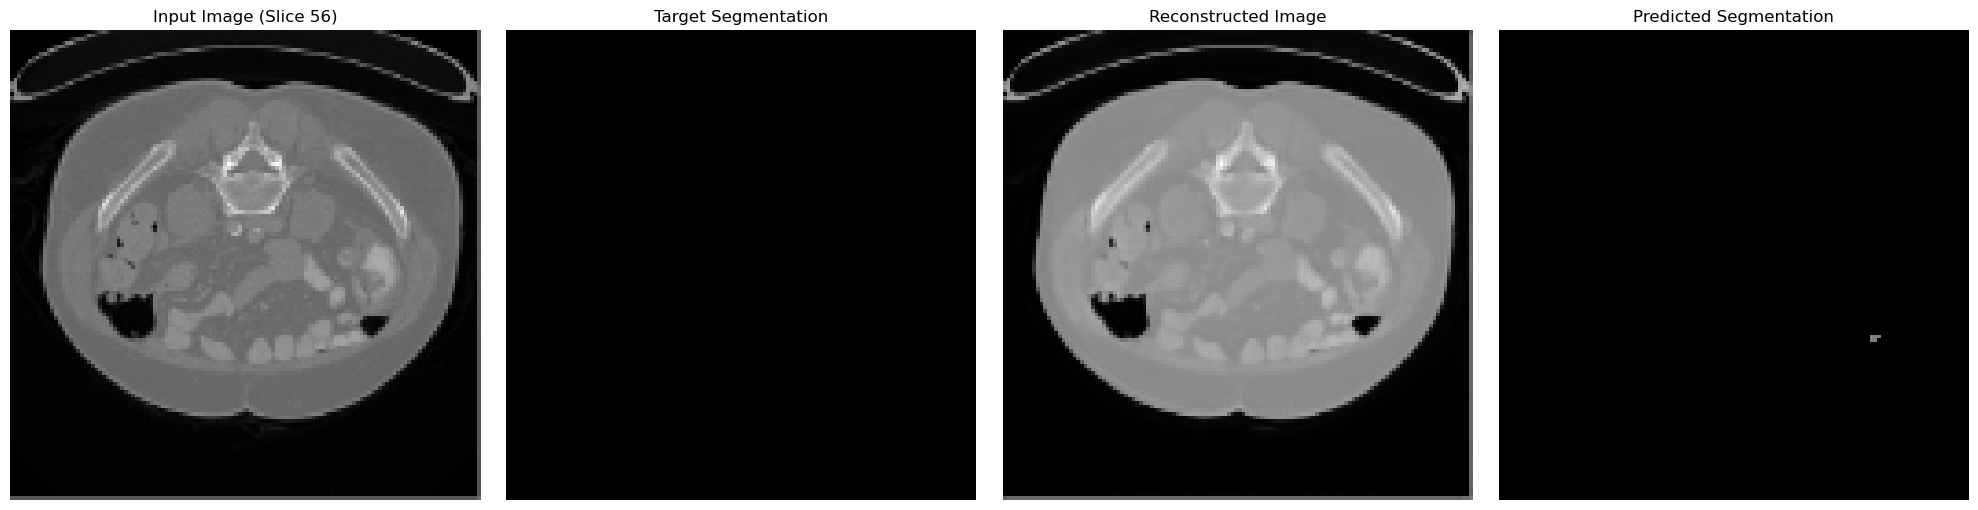

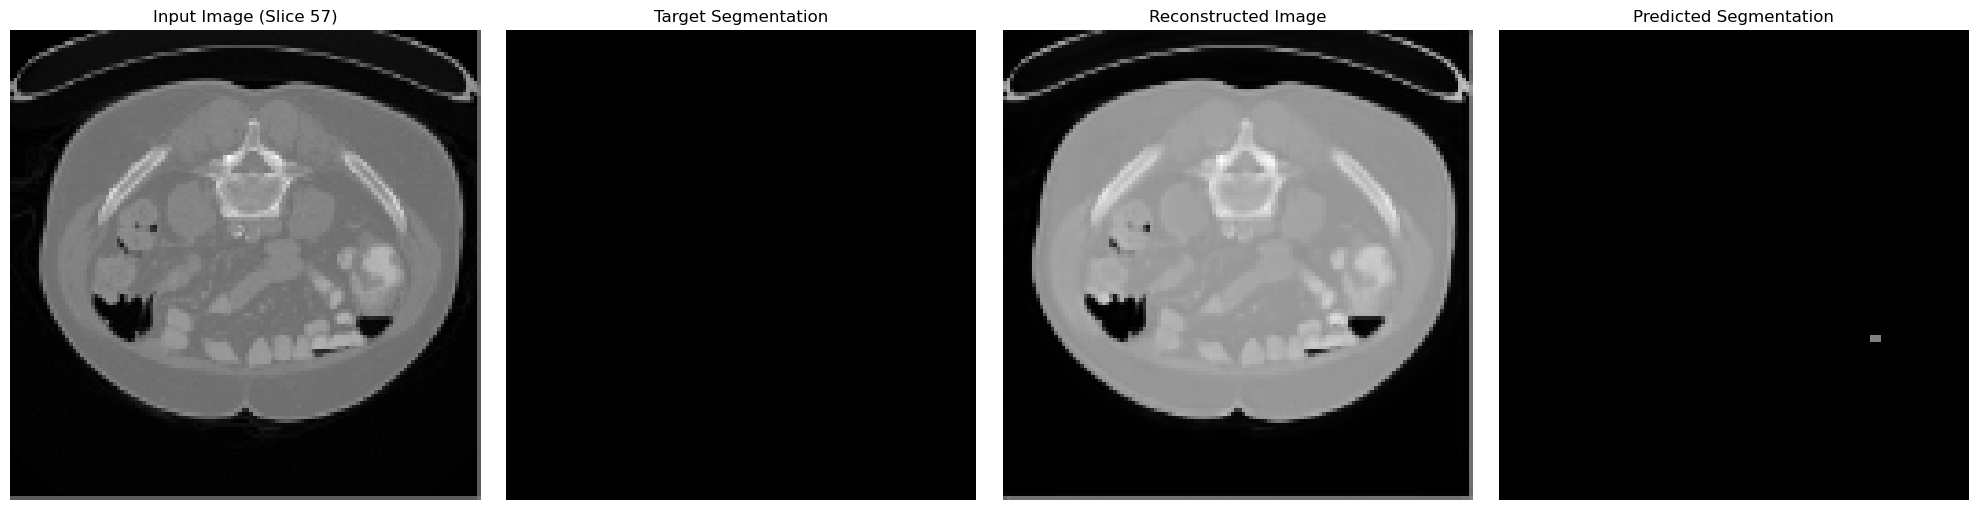

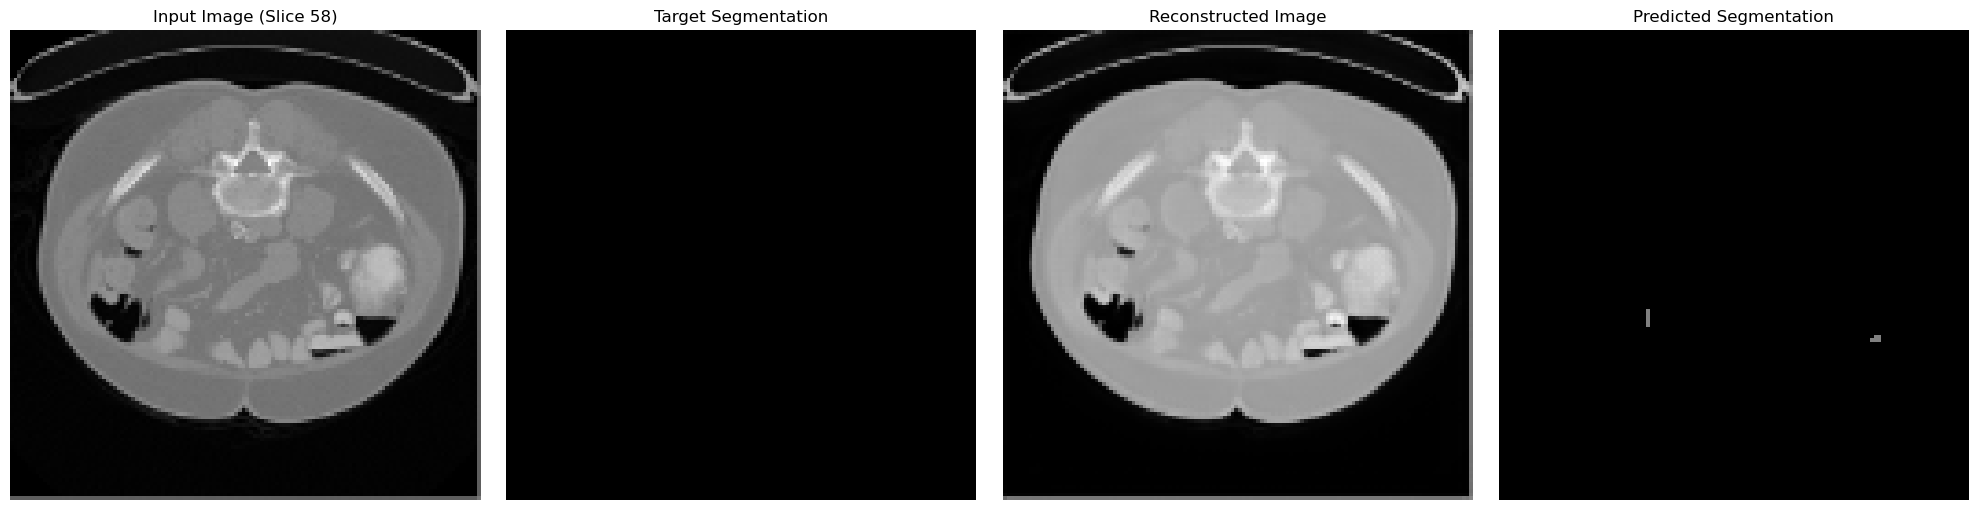

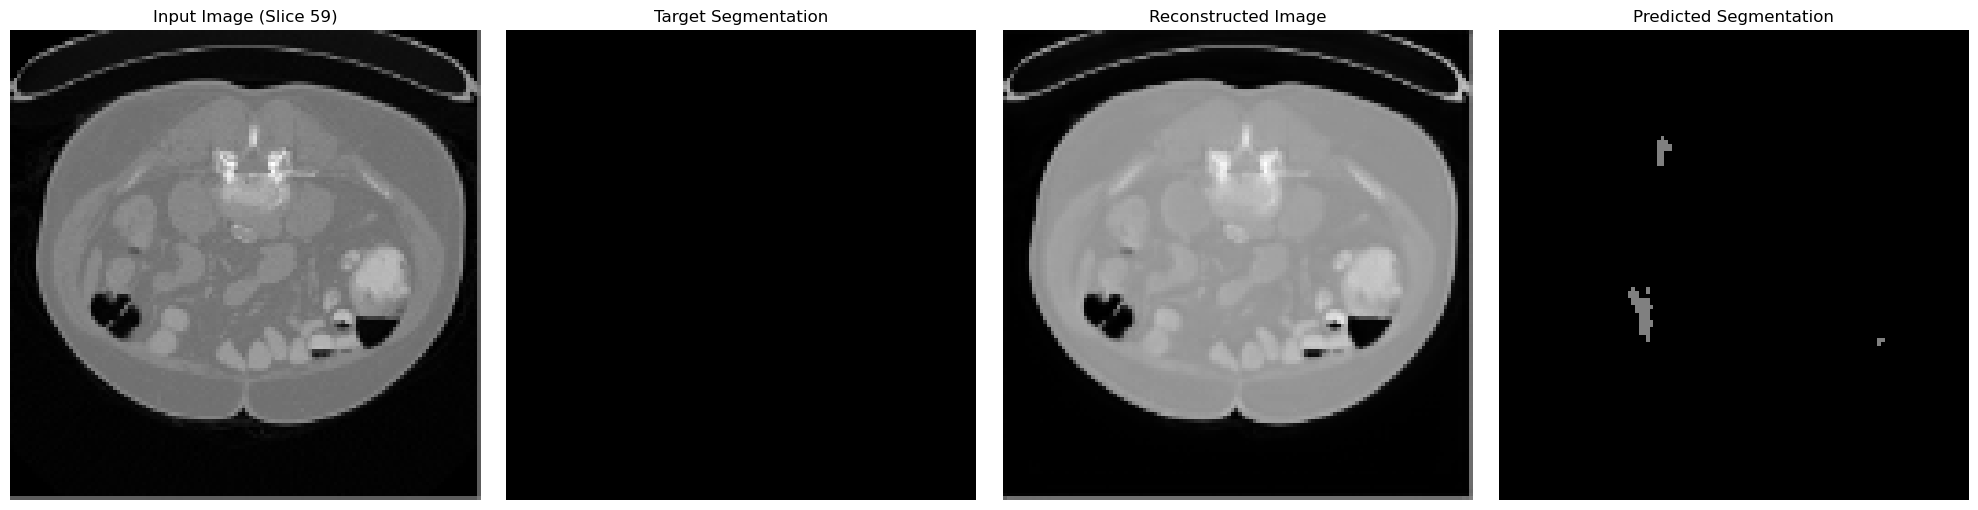

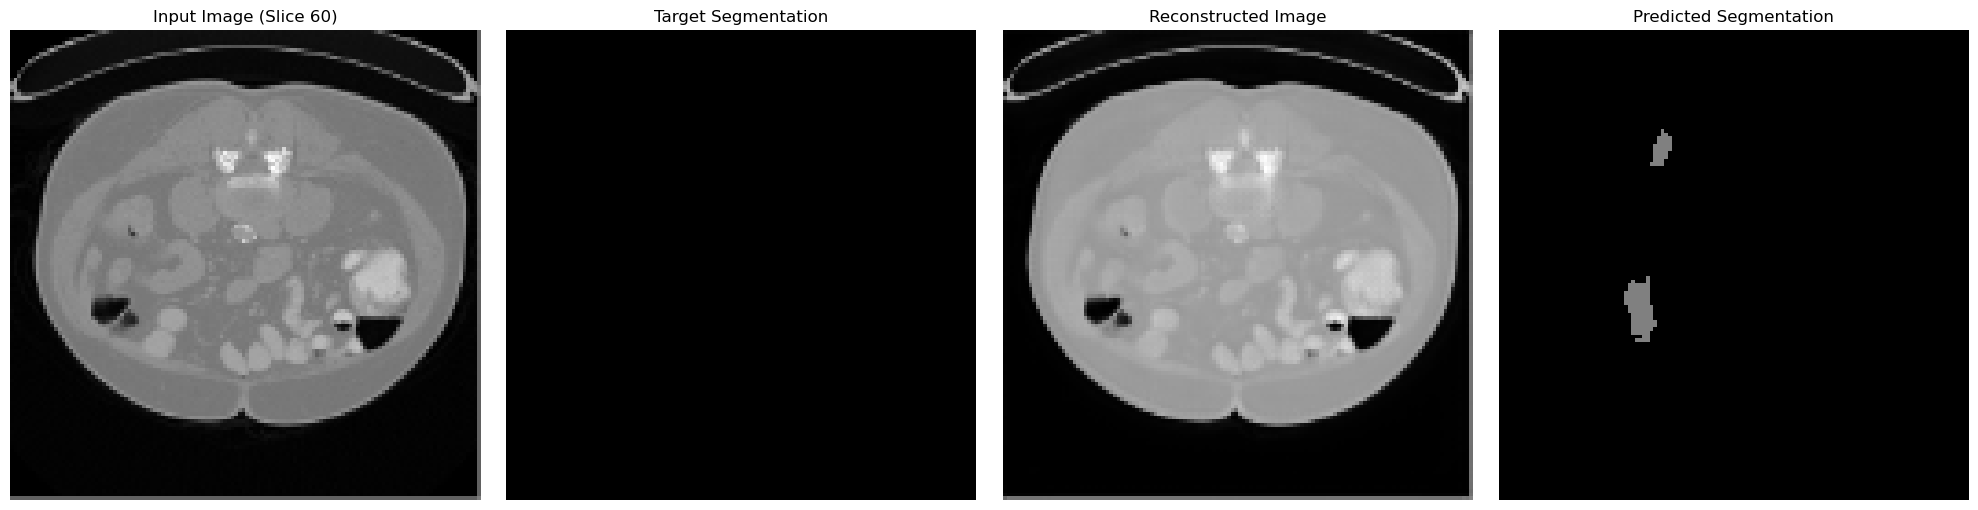

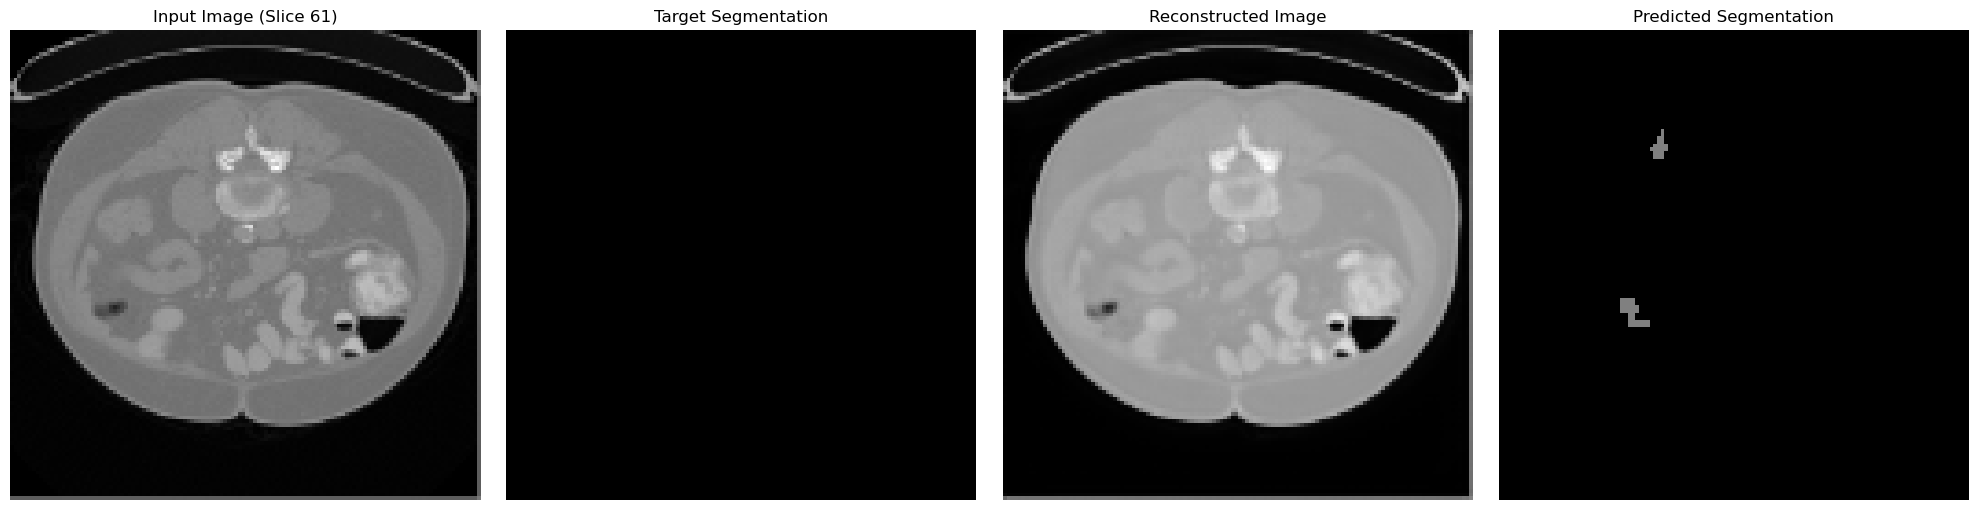

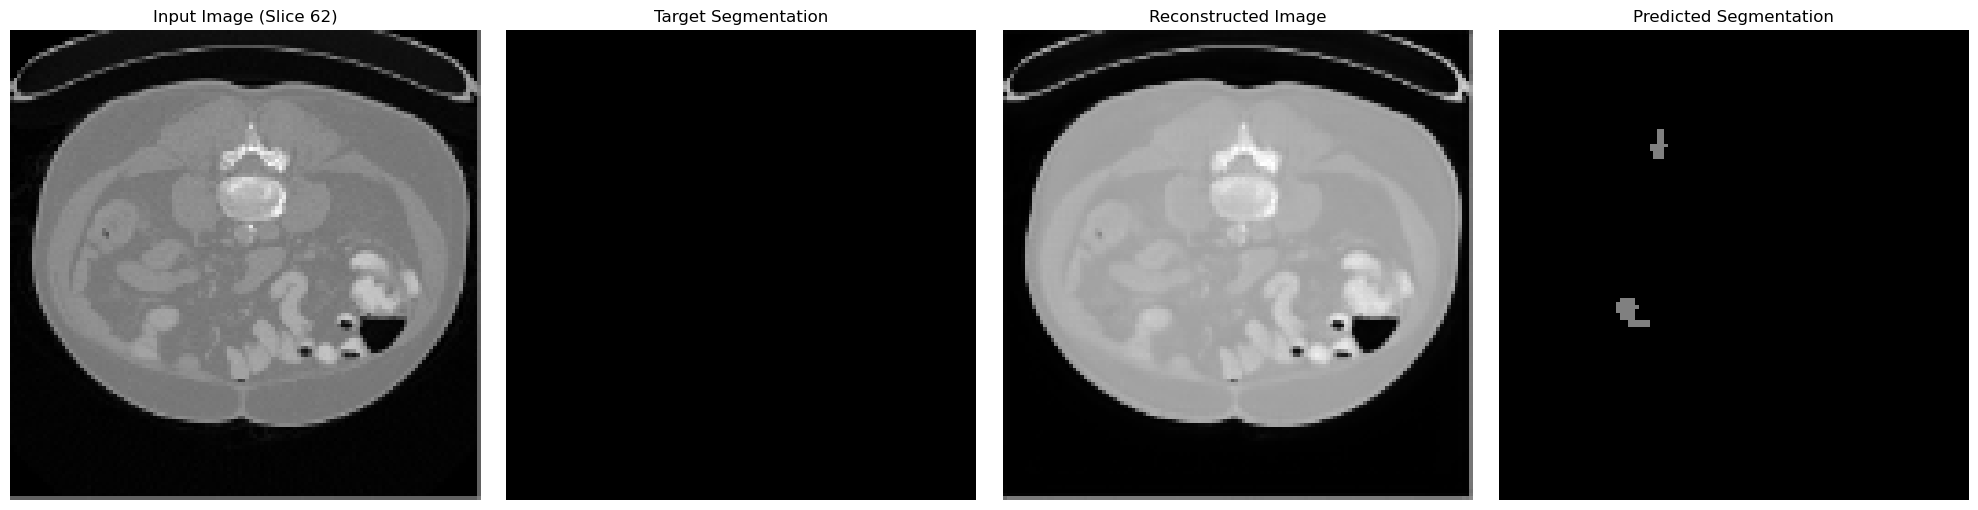

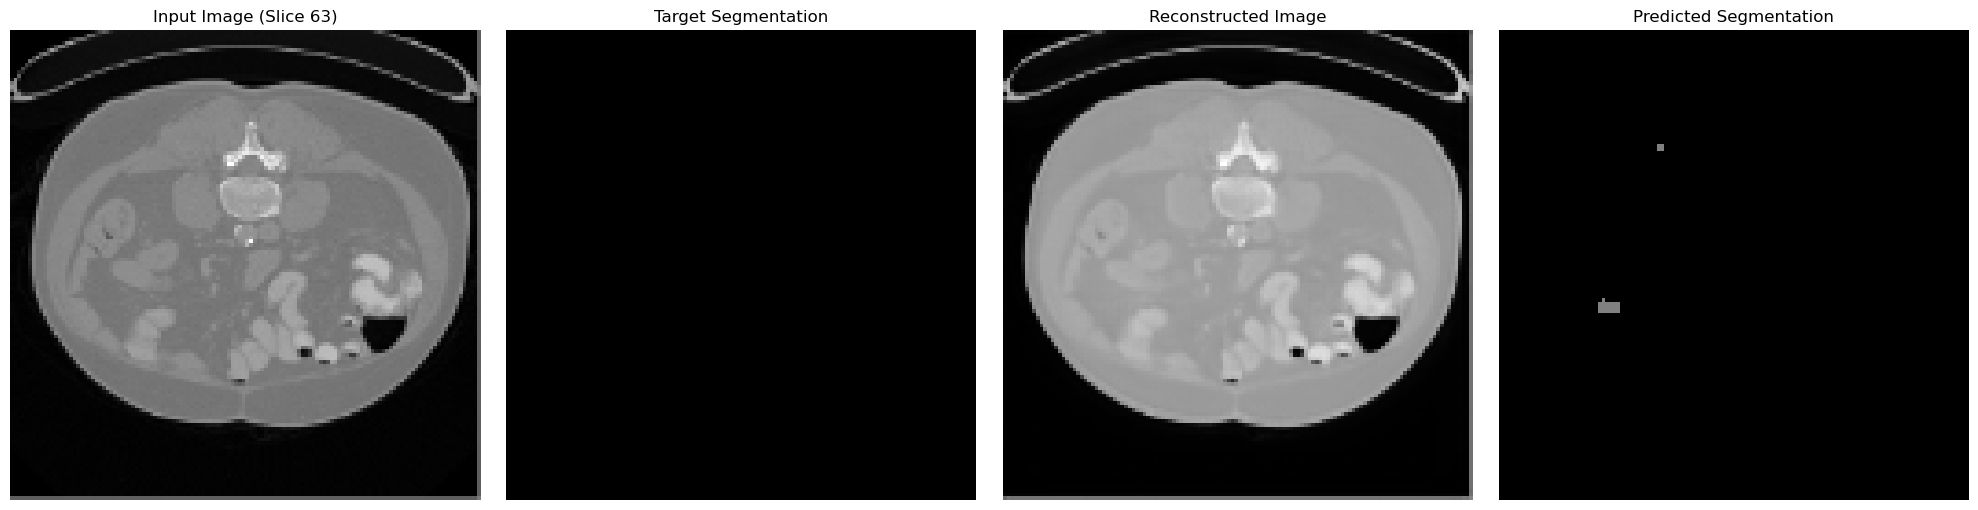

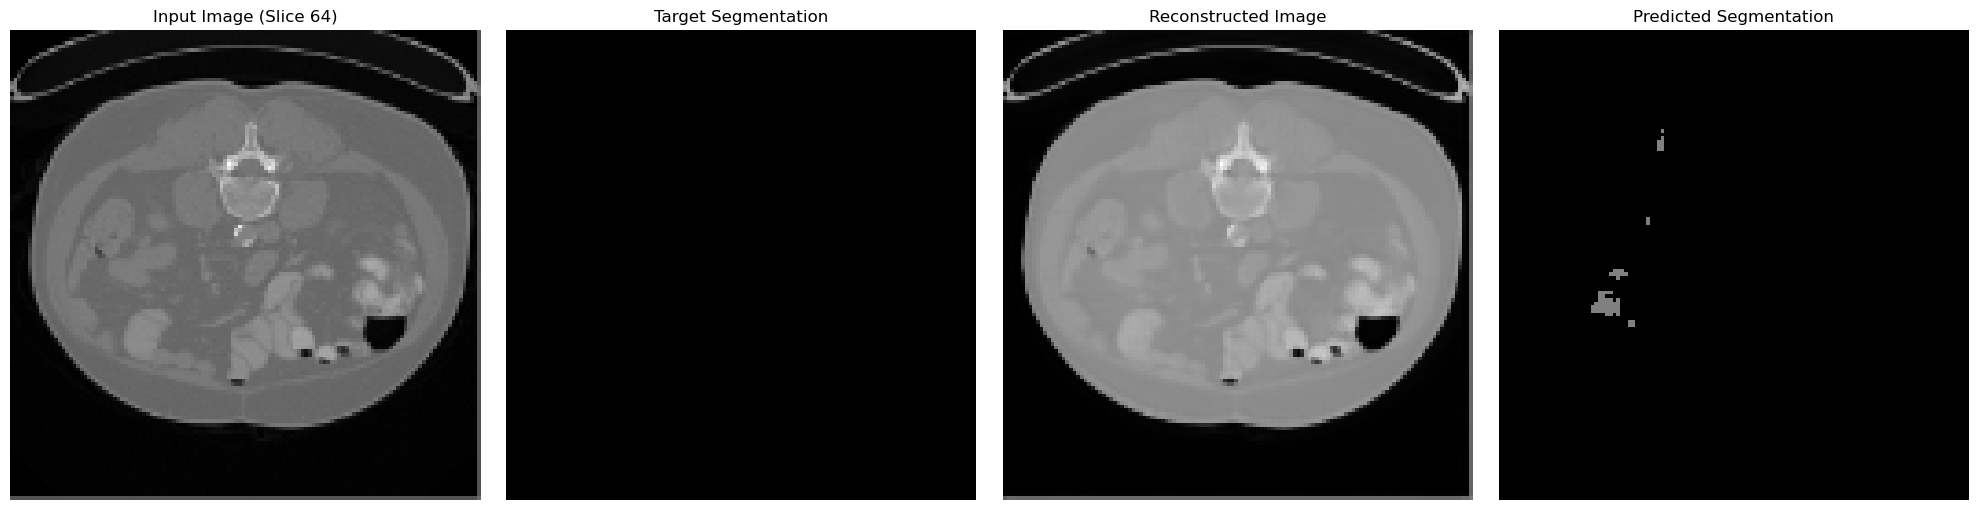

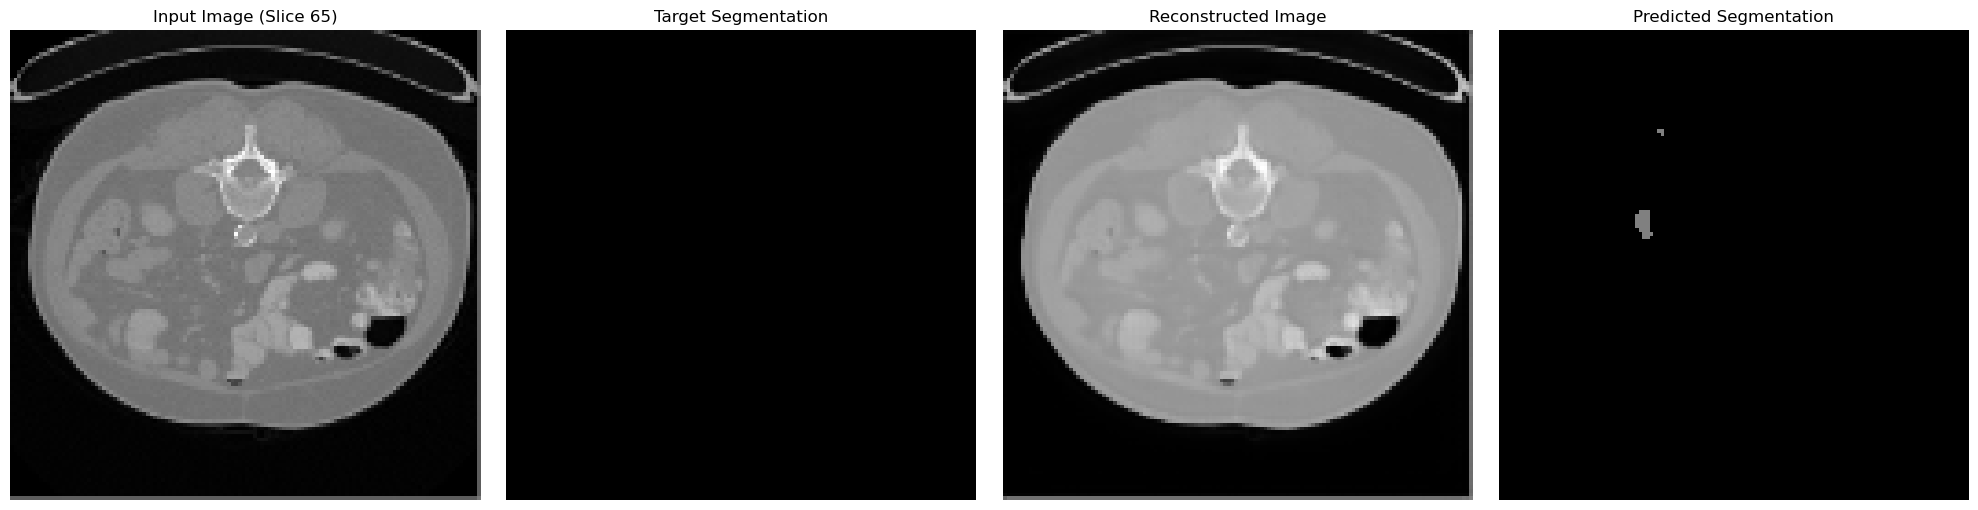

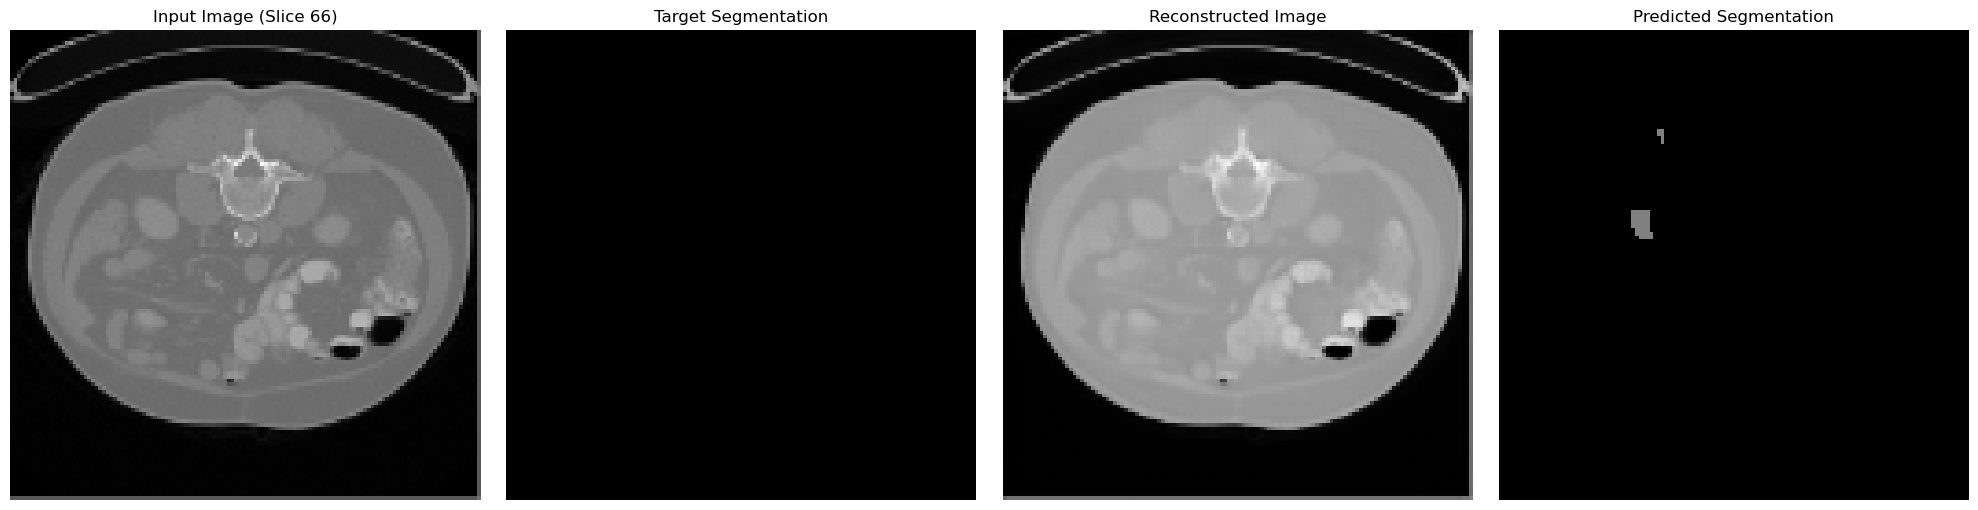

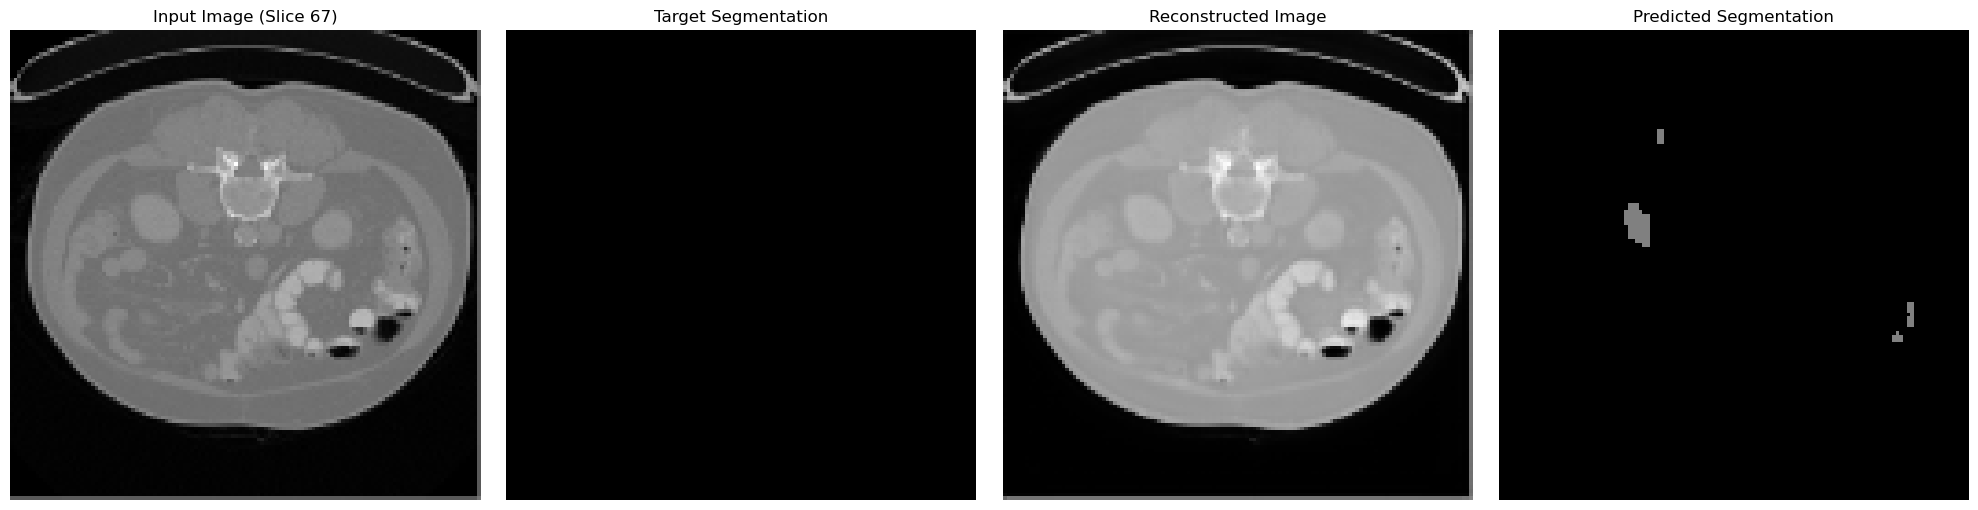

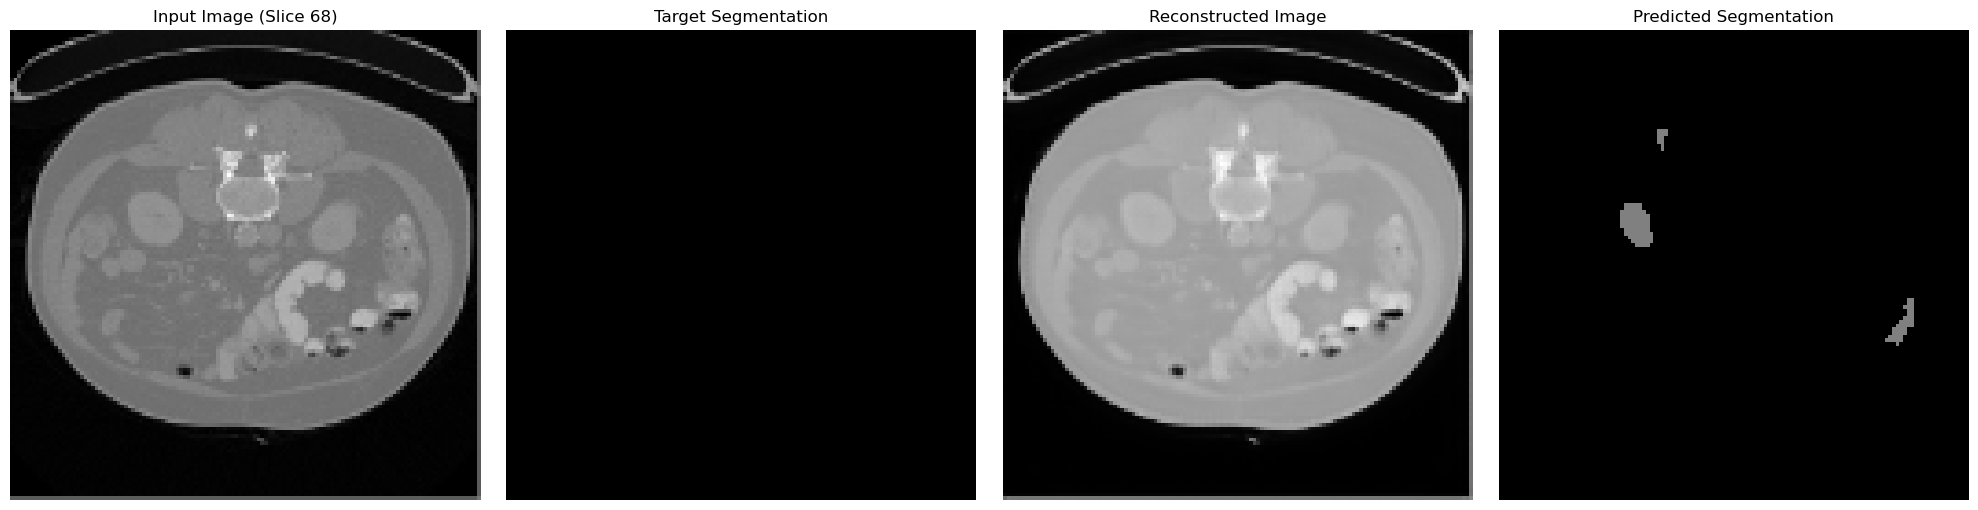

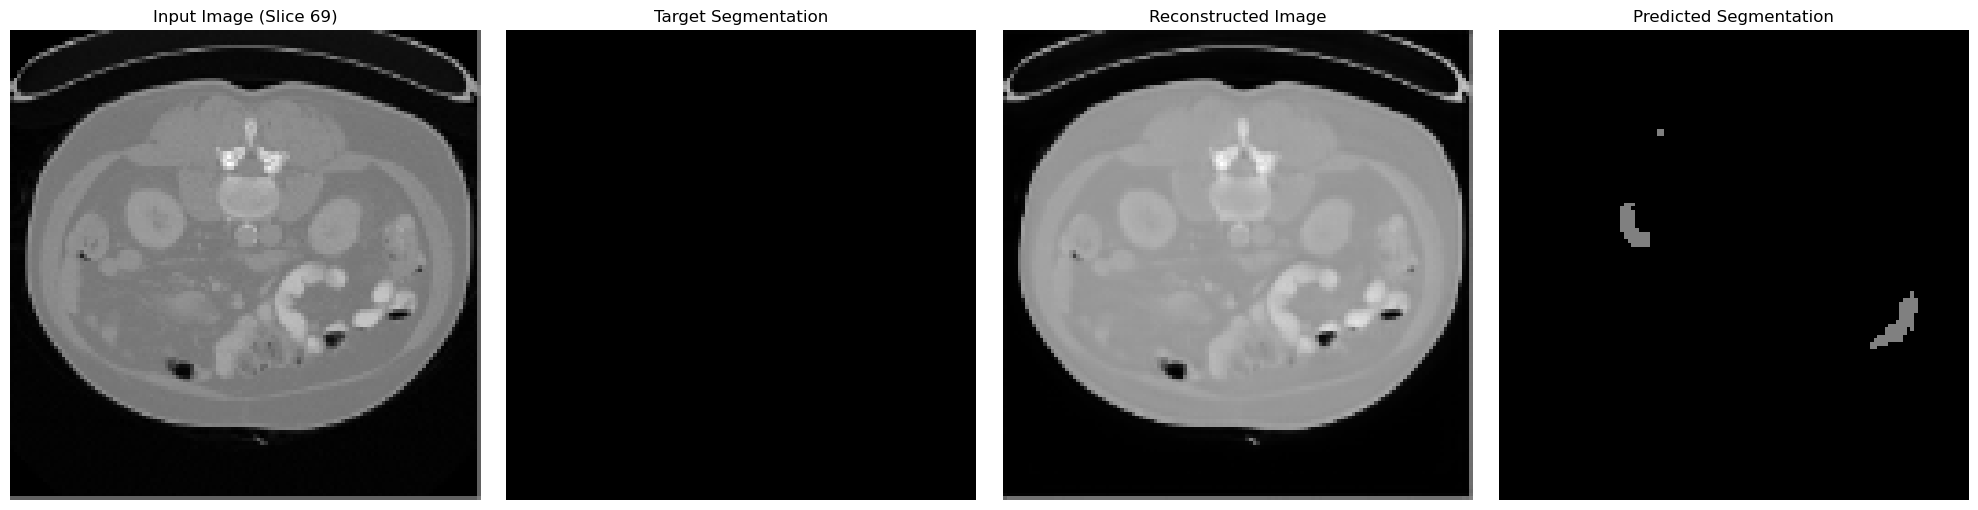

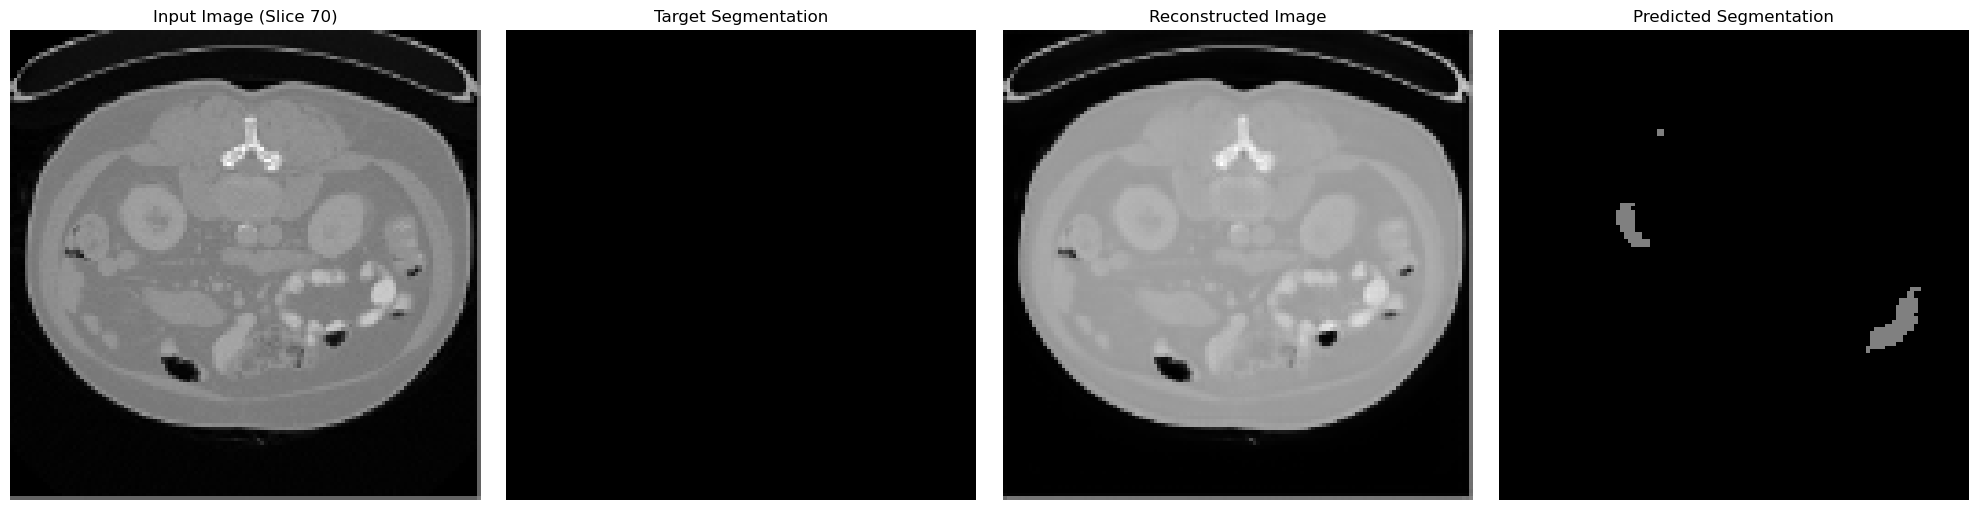

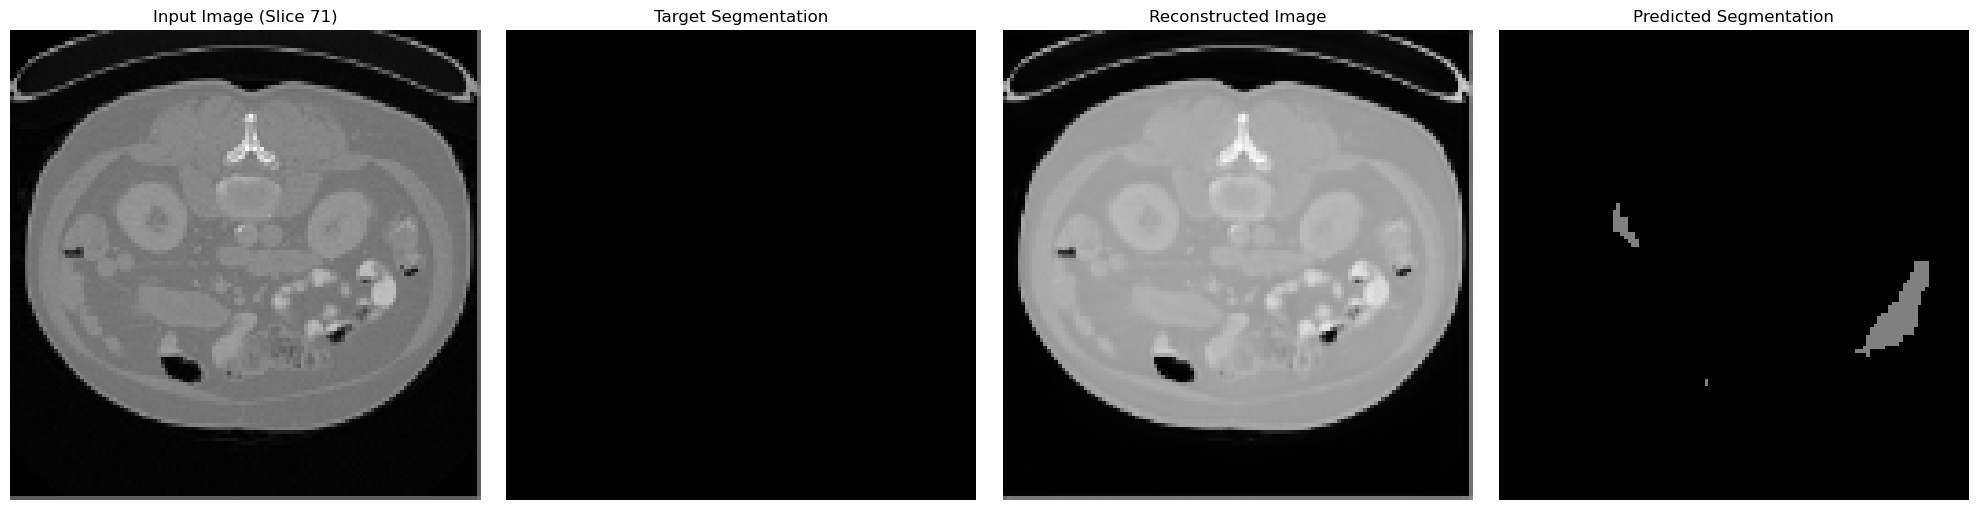

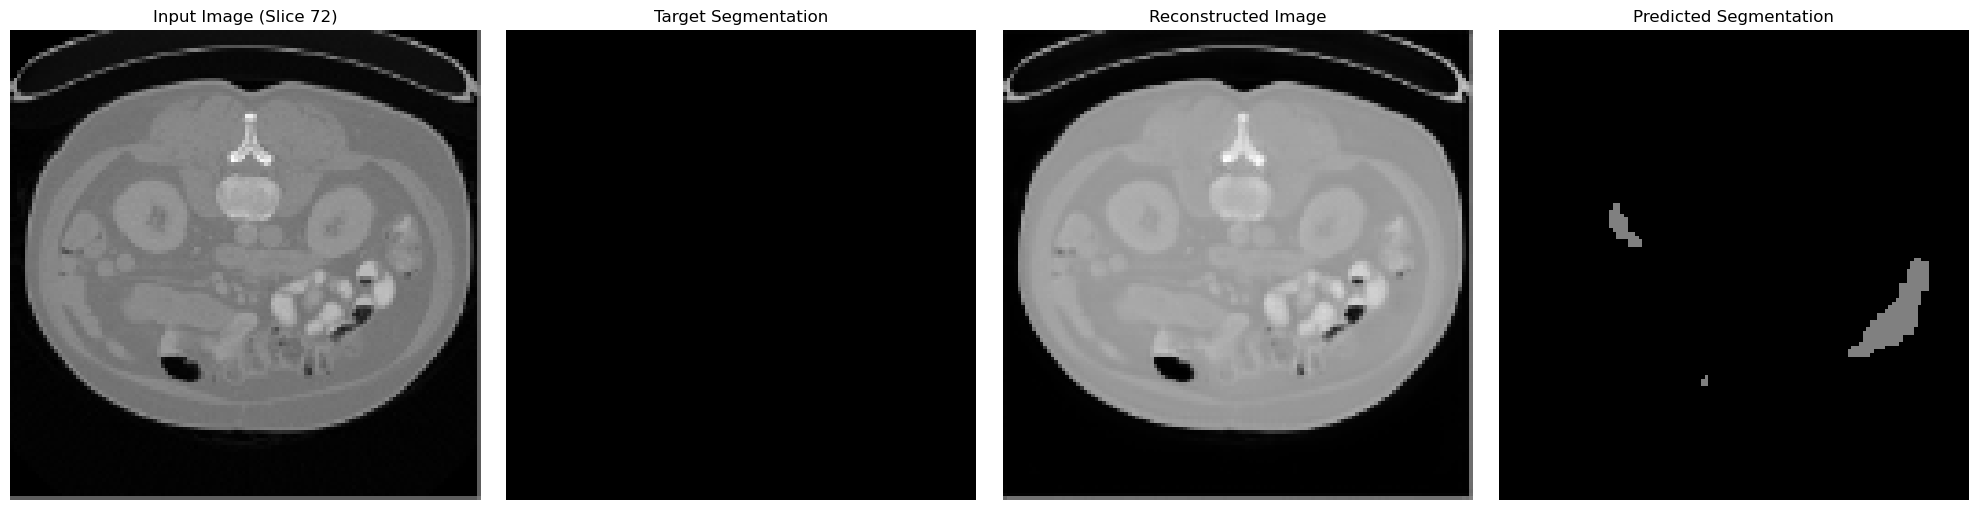

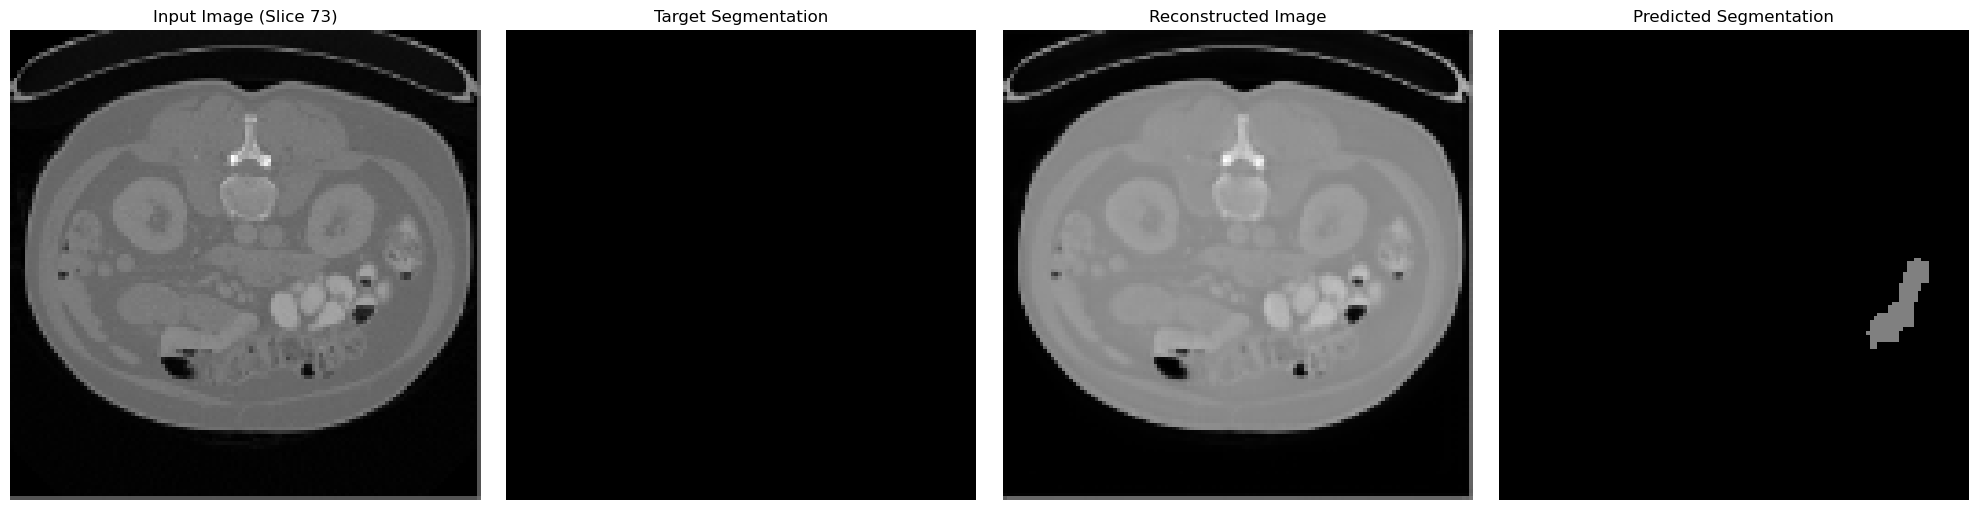

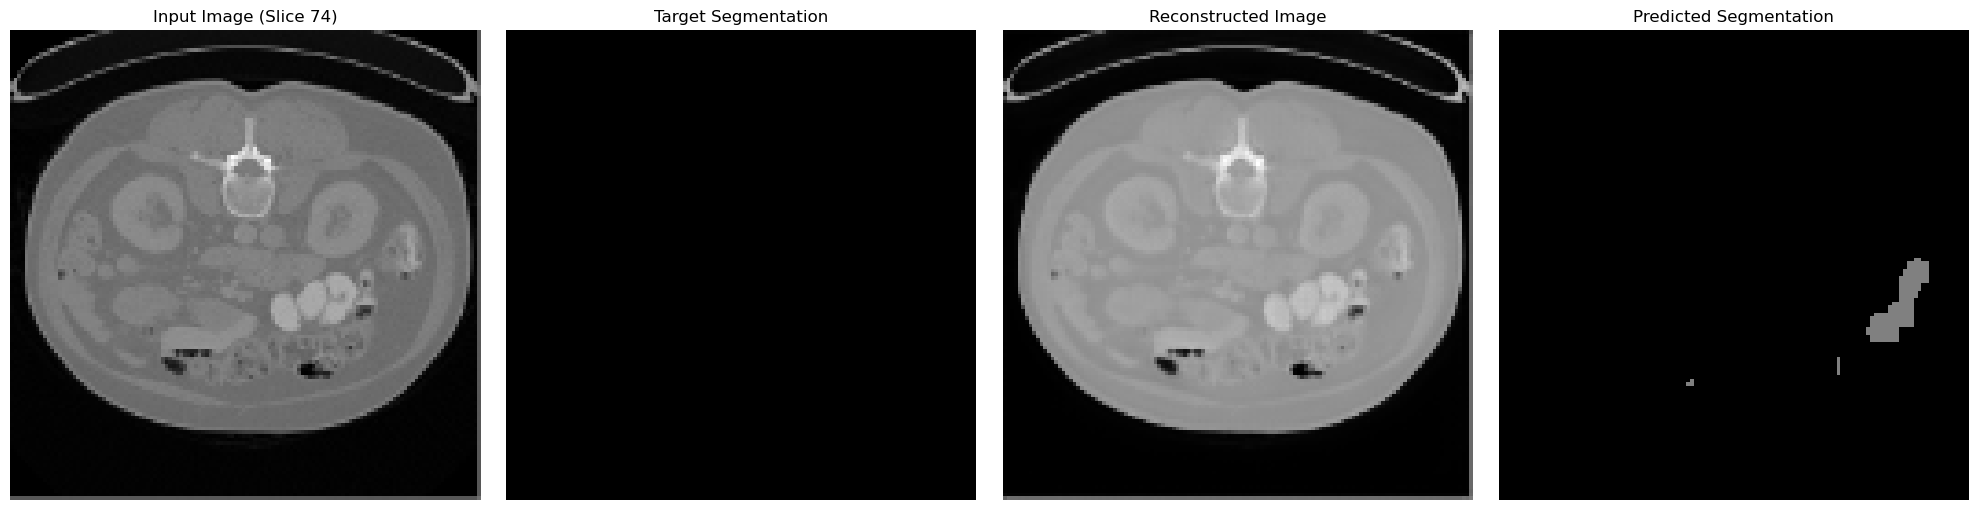

In [4]:
from func.utill import visualize_slices

for i in range(30):
    visualize_slices(x_labeled, y_labeled, recon_out, seg_out, slice_idx=45+i)